# The Kalman Filter

This filter is the optimal estimator for linear functions and Gaussian distributions.
The Kalman filter can be used as a solution to the online SLAM problem, defined as follows:

**Given:**

   - The robot's controls $u_{1:T} = \{u_1,u_2,u_3...,u_T\}$
   - Observations $z_{1:T} = \{z_1,z_2,z_3...,z_T\}$

**Wanted:**

   - Map of the environment $m$
   - Path of the robot $x_{0:T} = \{x_0,x_1,x_2...,x_T\}$
   
We will make a probabilistic estimation of the robot's path and the map according to the motion and observation models.


**Motion Model**

The motion model describes the relative motion of the robot. Some examples of motion model are the Odometry-based model (wheeled robots) or the velocity-based model (flying robots).
    
The motion model is represented by matrices and thus is a linear function.
    \begin{equation}
        x_t = A_tx_{t-1} + B_tu_t + \epsilon_t
    \end{equation}

- $A_t (n\times n)$ maps the state at $t$, given the previous state at $t-1$.
- $B_t (n\times l)$ describes state change from $t-1$ to $t$, given control command.

    
**Observation Model**

The observation or sensor model relates measurements with the robot's pose: what I am going to observe given that I know the pose or the map. The Beam-Endpoint model is characterized by a gaussian blur around the obstables. The Ray-cast model experiments an exponential decay and covers dynamic obstacles.

The linear mapping between the state and the observation space:
    \begin{equation}
        z_t = C_tx_{t} + \delta_t
    \end{equation}

- $C_t (k\times n)$ maps state $x_t$ to an observation $z_t$.

The Kalman filter is a recursive algorithm and it is computed as follows:


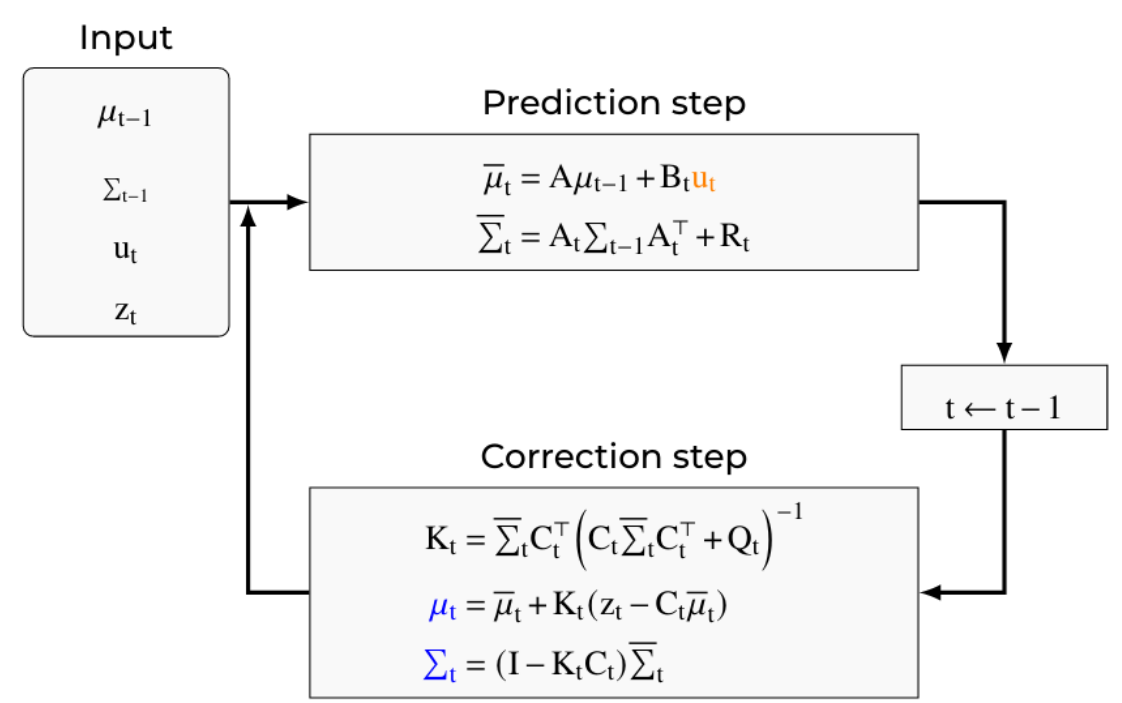

Where $Q_t$ and $R_t$ describe measurement and motion noise, $\mathbf{\mu}_{t}$ is the mean, $\textstyle\sum_t$ is the covariance (uncertainty), $K_t$ is the Kalman gain. The Kalman gain computes how certain I am about the prediction with respect to the motion.


We introduce to the algorithm our current estimate of where we have been in tearms of mean estimate and covariance matrix, as well as the new control command and the observations. We want to update the mean and the covariance matrix so we transit from t-1 to t.
We are computing a weighted sum with the Kalman gain weighting the prediction and the correction.

# The Extended Kalman Filter

However, in most real scenarios we do not have linear functions to describe the movements or the sensor model.
Non-linear functions lead to non-Gaussian distributions and we cannot use the Kalman filter anymore. This is resolved by the Extended Kalman Filter by local linearization. However, we're still assuming Gaussian noise and Gaussian uncertainties.

The algorithm for the Extended Kalman Filter is:

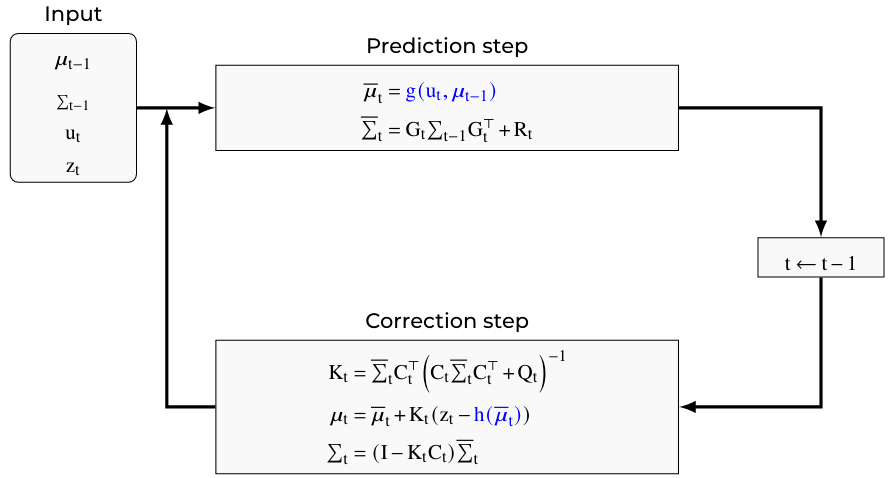

The terms highlighted in blue are those in which the EKF perform the local linearization. Hereafter, I will introduce how these terms are computed.

## Using the EKF to solve the SLAM problem

First we need to define our state vector, and the assumptions for the example that we are using in this notebook:

- Assumption: known correspondences. That is, when I get an observation, I know which landmark it is in my map.
- State space (for 2D plane) contains the robot pose (3 dimensions) and the landmark locations (2 dimensions each), and it's defined as:

\begin{equation}
    x_t = ( \underbrace{x,y,\theta}_{\text{robot's pose}},\underbrace{m_{1,x},m_{1,y}}_{\text{landmark 1}},...,\underbrace{m_{n,x},m_{n,y}}_{\text{landmark n}})^T
\end{equation}
                                            

- State representation (very compactly, with $x_R\rightarrow x)$:


\begin{equation}
    \underbrace{\begin{pmatrix}x\\m\end{pmatrix}}_{\mu}\underbrace{\begin{pmatrix}\textstyle\sum_{xx} \textstyle\sum_{xm}\\\textstyle\sum_{mx} \textstyle\sum_{mm}\end{pmatrix}}_{\textstyle\sum}
\end{equation}

With $\sum_{xx}$ representing the uncertainty around the pose, $\sum_{mm}$ the uncertainty about the landmark location, and $\sum_{xm}$ the link between the landmark locations and the position of the robot within the platform.
    

# Let's code!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from celluloid import Camera
from IPython.display import HTML
import numpy as np
import os
import math
import seaborn as sns
%matplotlib inline

### Auxiliary functions

In [2]:
def normalize_angle(phi):
    # Normalize phi to be between -pi and pi
    while(phi>np.pi):
        phi -= 2*np.pi;


    while(phi<-np.pi):
        phi += 2*np.pi

    phiNorm = phi

    return phiNorm


In [3]:
def normalize_all_bearings(z):
    # Go over the observations vector and normalize the bearings
    # The expected format of z is [range; bearing; range; bearing; ...]
    
    for i in range (1,z.shape[0],2):
        z[i] = normalize_angle(z[i])
        
    zNorm = z
    return zNorm

In [4]:
def plot_state(mu,sigma,landmarks,observedLandmarks,fig,ax):
    
    # Visualizes the state of the EKF SLAM algorithm.
    #
    # The resulting plot displays the following information:
    # - map ground truth (black +'s)
    # - current robot pose estimate (red)
    # - current landmark pose estimates (blue)
    # - visualization of the observations made at this time step (line between robot and landmark)
    
    # using seaborn, set background grid to gray
    sns.set_style("dark")
    #fig,ax = plt.subplots()

    ax.set_xticks([x for x in range(-2,12)],minor=True )
    ax.set_yticks([y for y in range(-2,12)],minor=True)

    # Plot grid on minor axes in gray (width = 1)
    plt.grid(which='minor',ls='-',lw=1, color='white')

    # Plot grid on major axes in larger width
    plt.grid(which='major',ls='-',lw=2, color='white')


    # Draw the robot
    ax.text(mu[0], mu[1], 'o', ha='center', va='center', color='black', fontsize=20)
    e = plot_conf_ellipse(mu[0:3],sigma[0:3,0:3], 0.6, 'red')
    ax.add_patch(e)


    # Draw the ground truth of the landmarks
    for i,l in enumerate(landmarks):
        ax.text(l[0], l[1], 'x', ha='center', va='center', color='black', fontsize=20)
        if (observedLandmarks[0][i] == 1.0):
            # plot landmark ellipse
            e = plot_conf_ellipse(mu[2*i+3:2*i+5],sigma[2*i+3:2*i+5,2*i+3:2*i+5], 0.6, 'blue')
            ax.add_patch(e)

    return fig
        
        

In [5]:
from scipy.stats.distributions import chi2
def plot_conf_ellipse(x,C,alpha,color):
    # Calculate unscaled half axes
    sxx = C[0,0] 
    syy = C[1,1] 
    sxy = C[0,1]
    # Remove imaginary parts in case of neg. definite C
    a = np.sqrt(0.5*(sxx+syy+np.sqrt((sxx-syy)**2+4*sxy**2))).real   # always greater
    b = np.sqrt(0.5*(sxx+syy-np.sqrt((sxx-syy)**2+4*sxy**2))).real   # always smaller

    
    # Scaling in order to reflect specified probability
    
    a = a*np.sqrt(chi2.ppf(alpha, df=2))
    b = b*np.sqrt(chi2.ppf(alpha, df=2))
    
    # Calculate inclination (numerically stable)
    if math.isclose(sxx, syy, rel_tol=0.1): # this function launches a warning
        angle = 0.5*np.arctan(2*sxy/(sxx-syy))
    elif (sxy==0):
        angle = 0
    elif (sxy>0):
        angle = np.pi/4
    elif (sxy<0):
        angle = -np.pi/4
        

    return Ellipse((x[0],x[1]), a, b, angle, edgecolor = color, facecolor = color, alpha = 0.5)

    

## Prediction step: defining $g(u_t,\mu_{t-1})$

In this step we only update the pose of the robot $x,y,\theta$ and its covariance $\sum_{xx}$ according to the motion model $g$. Note that since we are just considering the robot's movement, without taking into account the sensor's measurements yet, the landmarks locations are not updated in this step.

### The motion model

Here the motion model considered is the Odometry Model:
- The robot moves from $[\overline{x},\overline{y},\overline{\theta}]$ to $[\overline{x}',\overline{y}',\overline{\theta}']$
- We have odometry information $u = [\delta_{rot1},\delta_{rot2},\delta_{trans}]$

\begin{equation}
\delta_{trans} = \sqrt{(\overline{x}'-\overline{x})^2+(\overline{y}'-\overline{y})^2}
\end{equation}

\begin{equation}
\delta_{rot1} = atan2(\overline{y}'-\overline{y},\overline{x}'-\overline{x})-\overline{\theta}
\end{equation}

\begin{equation}
\delta_{rot2} = \overline{\theta}'-\overline{\theta}-\delta_{rot1}
\end{equation}

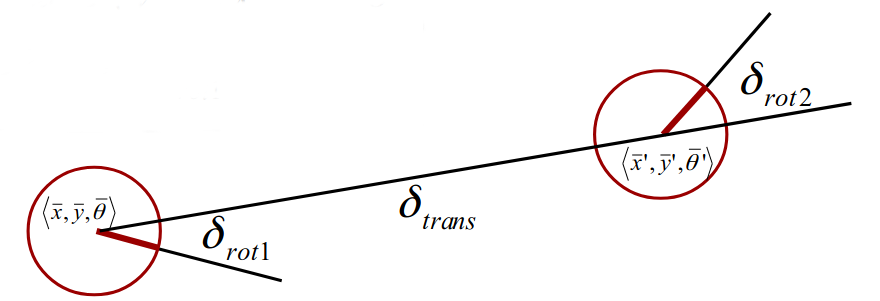

Thus, our odometry motion model (without the noise model) that we will use to update the robot pose in the state vector $\mu$ is:

\begin{equation}
x' = x + \delta_{trans}\cos{(\theta+\delta_{rot1})}
\end{equation}

\begin{equation}
y' = y + \delta_{trans}\sin{(\theta+\delta_{rot1})}
\end{equation}

\begin{equation}
\theta' = \theta + \delta_{rot1} + \delta_{rot2}
\end{equation}

Next, we update the elements in the covariance matrix associated to the robot pose by performing a local linearization of the function. This is achieved with the partial derivatives of the previous functions, that is, with the Jacobian matrix $G$.
\begin{equation}
G_t^x = \frac{\delta g(u_t,\mu')}{\delta (x,y,\theta)}
\end{equation}
Remember that we're only updating the robot values in the state space. That is, our Jacobian will have the structure:
\begin{equation}
G_t = \begin{bmatrix}
\frac{\delta g(u_t,\mu')}{\delta (x,y,\theta)} & \textbf{0}\\
\textbf{0} & \textbf{I}
\end{bmatrix} 
\end{equation}



In [22]:
def prediction_step( mu, sigma, u):
    ''' Updates the belief concerning the robot pose according to the motion model,
    args:
    - mu :: 2N+3 x 1 vector representing the state mean.
    - sigma :: 2N+3 x 2N+3 covariance matrix.
    - u: odometry reading (r1, t, r2).    
    
    '''
    m,n = sigma.shape
    
    # Compute new mu based on the noise-free (odometry-based) motion model
    mu[0,0] = mu[0,0] + u['t'] * np.cos(mu[2,0] + u['r1']) # x
    mu[1,0] = mu[1,0] + u['t'] * np.sin(mu[2,0] + u['r1']) # y
    mu[2,0] = mu[2,0] + u['r1'] + u['r2'] # y
    mu[2,0] = normalize_angle(mu[2,0])
    
    # Compute the 3x3 Jacobian Gx of the motion model
    Gx = np.identity(3)
    Gx[0,2] = - u['t'] * np.sin(mu[2,0] + u['r1'])
    Gx[1,2] =   u['t'] * np.cos(mu[2,0] + u['r1'])
    
    # Construct the full Jacobian G
    G = np.concatenate((Gx,np.zeros((3,n-3))),axis = 1)
    aux = np.concatenate((np.zeros((n-3,3)), np.identity(n-3)),axis = 1)
    G = np.concatenate((G,aux), axis = 0)
    
    # Motion noise R
    motionNoise = 0.1
    R3 = np.identity(3)*motionNoise
    R3[2,2] = motionNoise/10
    
    R = np.zeros((sigma.shape))
    
    R[0:3, 0:3] = R3
    
    # Compute predicted sigma
    sigma = np.matmul(G,np.matmul(sigma,G.T)) +R # i.e.  sigma = G*sigma*G.T + R

    
    return mu,sigma
                

# Correction step

Once the pose has been update, it's time for the correction. 

- Predicted measurement $h(x)$ : we need to predict what the robot sees. For that, we take the current position of the robot, and the position of the landmarks in the map, and with that we compute our predicted measurement.
- Obtained measurement $z$: we take the real observations of the landmarks according to the sensor. 
- Data association: we compute the discrepancy between $h(x)$ and $z$.
- Update step: finally, all the elements in $\mu$ and $\sum$ are updated


In [7]:
def correction_step(mu,sigma,z,observedLandmarks):
    ''' Updates the belief, i. e., mu and sigma after observing landmarks, according to the sensor model.
        The employed sensor model measures the range and bearing of a landmark.
        mu: 2N+3 x 1 vector representing the state mean.
        The first 3 components of mu correspond to the current estimate of the robot pose [x; y; theta]
        The current pose estimate of the landmark with id = j is: [mu(2*j+2); mu(2*j+3)]
        sigma: 2N+3 x 2N+3 is the covariance matrix
        z: struct array containing the landmark observations.
        Each observation z(i) has an id z(i).id, a range z(i).range, and a bearing z(i).bearing
        The vector observedLandmarks indicates which landmarks have been observed at some point by the robot.
        observedLandmarks(j) is false if the landmark with id = j has never been observed before.
    '''
    # Number of measurements in this time step
    m = z.shape[0]
    # Number of dimensions to mu
    dim = mu.shape[0]
    # Z: vectorized form of all measurements made in this time step: [range_1; bearing_1; range_2; bearing_2; ...; range_m; bearing_m]
    # ExpectedZ: vectorized form of all expected measurements in the same form.
    # They are initialized here and should be filled out in the for loop below
    Z = np.zeros([m*2, 1],float)
    expectedZ = np.zeros([m*2, 1],float)
    
    # Iterate over the measurements and compute the H matrix
    # (stacked Jacobian blocks of the measurement function)
    # H will be 2m x 2N+3
    H = []
    
    j = 0
    for i,row in z.iterrows():
        # Get the id of the landmark corresponding to the i-th observation
        landmarkId = int(row['r1']) # r1 == ID here
        #landmarkId = landmarkId -1 # adapt the 1-9 range to 0-8 range of the array
        
        # If the landmark is obeserved for the first time:
        if (observedLandmarks[0][landmarkId-1] == 0):
            # Initialize its pose in mu based on the measurement and the current robot pose:
            a = float(row['t']*np.cos(row['r2']+mu[2]))
            b = float(row['t']*np.sin(row['r2']+mu[2]))
            mu[2*landmarkId+1 : 2*landmarkId+3] = mu[0:2] + np.array([[a], [b]])
       
            # Indicate in the observedLandmarks vector that this landmark has been observed
            observedLandmarks[0][landmarkId-1] = 1  
            
        # Add the landmark measurement to the Z vector   
        Z[2*j] = row['t']
        Z[2*j+1] = row['r2']
        
        # Use the current estimate of the landmark pose
        # to compute the corresponding expected measurement in expectedZ:
        delta = mu[2 * landmarkId + 1 : 2 * landmarkId + 2+1] - mu[0:2]
        q = np.matmul(delta.T,delta)
        
        expectedZ[2*j] = math.sqrt(q)
        expectedZ[2*j+1] = normalize_angle(np.arctan2(delta[1],delta[0]) - mu[2])      
        
        delta0 = float(delta[0])
        delta1 = float(delta[1])
        
        # Compute the Jacobian Hi of the measurement function h for this observation
        Hi = 1/q * np.array([[float(-math.sqrt(q)*delta0),-math.sqrt(q)*delta1, 0, math.sqrt(q)*delta0, math.sqrt(q)*delta1], [ delta1, -delta0, float(-q), -delta1, delta0] ])
        
        # Map Jacobian Hi to high dimensional space by a mapping matrix Fxj
        Fxj = np.zeros([5,dim])
        Fxj[0:3,0:3] = np.identity(3)
        Fxj[3,2*landmarkId+1] = 1
        Fxj[4,2*landmarkId+2] = 1
        
        Hi = np.matmul(Hi, Fxj)

        
        # Augment H with the new Hi     

        H.append(Hi)
        
        j+=1


        
    # Construct the sensor noise matrix Q
    Q = 0.01*np.identity(2*m)
    
    # Compute the Kalman gain
    # K = sigma * H.T * inv(H * sigma * H.T + Q)
    Hnp = np.asarray(H).reshape((2*m,dim))
    sigmaxHt = np.matmul(sigma,Hnp.T)
    inverse = np.linalg.inv(np.matmul(Hnp,sigmaxHt)+Q)    
    K = np.matmul(sigmaxHt,inverse)
    
    # Compute the difference between the expected and recorded measurements.
    # Remember to normalize the bearings after subtracting!
    
    diffZ = normalize_all_bearings(Z-expectedZ)

    # Finish the correction step by computing the new mu and sigma.
    # Normalize theta in the robot pose.
    mu = mu + np.matmul(K, diffZ)
    # sigma = (eye(dim) - K * H) * sigma
    sigma = np.matmul((np.identity(dim) - np.matmul(K, Hnp)), sigma)
    
    return mu, sigma, observedLandmarks


    
                                                             
                                                

## Initialization

### Data preprocessing

First, we need to read the world data and the sensor measurements. 
The world data contains the landmark positions. The sensor data includes the odometry measurements and the range-bearing sensor measurements.

In [8]:
def read_world(filename,path):
    landmarks = pd.read_csv(path+filename,delimiter = ' ',header=None, names = ['x','y'])
    return (np.asarray(landmarks))
def read_data(filename,path):
    data = pd.read_csv(path + filename,delimiter = ' ',header=None, names = ['sensor','r1','t','r2']) # or id, range and bearing for sensor
    return (data)

world_ldmrks = read_world('/data/ekf_world.dat',os.path.abspath(os.getcwd()))
data = read_data('/data/ekf_sensor_data.dat',os.path.abspath(os.getcwd()))

We read the sensor data file and assign a time step for each

In [9]:
data = read_data('/data/ekf_sensor_data.dat',os.path.abspath(os.getcwd()))
indexodometry = data[ (data['sensor'] == 'ODOMETRY')].index

timestepindex = []
timestep = 0
for i in range (0,data.shape[0]):
    if(timestep+1 < indexodometry.shape[0]):
        if (i < indexodometry[timestep+1]) :
            timestepindex.append(timestep)
        else:
            timestep +=1
            timestepindex.append(timestep)
    else:
        timestepindex.append(timestep)

data.insert(0, "timestep", timestepindex, True)
data

,timestep,sensor,r1,t,r2
0,0,ODOMETRY,0.100692,0.100073,0.000171
1,0,SENSOR,1.000000,1.896454,0.374032
2,0,SENSOR,2.000000,3.853678,1.519510
3,1,ODOMETRY,0.099366,0.099968,-0.000241
4,1,SENSOR,1.000000,1.839227,0.248026
...,...,...,...,...,...
1538,330,SENSOR,5.000000,4.951031,-1.512977
1539,330,SENSOR,6.000000,4.917189,-0.862938
1540,330,SENSOR,7.000000,-0.035066,0.975887
1541,330,SENSOR,8.000000,1.900675,3.144946


Once the data is stored in a pandas dataframe, we can for example read the odometry measurements for the time step 0 as:

In [10]:
data.loc[(data['timestep'] == 0) & (data['sensor'] == 'ODOMETRY')]

,timestep,sensor,r1,t,r2
0,0,ODOMETRY,0.100692,0.100073,0.000171


Or the range bearing measurement for the time step 330 as:

In [11]:
data.loc[(data['timestep'] == 330) & (data['sensor'] == 'SENSOR')]

,timestep,sensor,r1,t,r2
1536,330,SENSOR,3.0,3.510814,0.993067
1537,330,SENSOR,4.0,4.925102,-2.218075
1538,330,SENSOR,5.0,4.951031,-1.512977
1539,330,SENSOR,6.0,4.917189,-0.862938
1540,330,SENSOR,7.0,-0.035066,0.975887
1541,330,SENSOR,8.0,1.900675,3.144946
1542,330,SENSOR,9.0,4.171552,0.072790


Get the number of landmarks in the map

In [12]:
N = world_ldmrks.shape[0]
N

9

observedLandmarks is a vector that keeps track of which landmarks have been observed so far.
observedLandmarks(i) will be true if the landmark i has been observed at some point

In [13]:
observedLandmarks = np.zeros((1,N))

### Initializing the belief

Given that we know the number of landmarks in our map, we can define the shape of the mean and the covariance matrix:

- mu: 2N+3x1 vector representing the mean of the normal distribution.
The first 3 components of mu correspond to the pose of the robot, and the landmark poses (xi, yi) are stacked in ascending id order.

- sigma: (2N+3)x(2N+3) covariance matrix of the normal distribution.

Everything is completely unknown in the beginnig, so we define the starting point as our coordinate system. That is, $\mu = \textbf{0}$. Since we are completely certain about that (because we've defined it), the corresponding values in sigma are also zero $\sum_{xx} = \textbf{0}$. However, we don't know anything about the landmarks, because we haven't seen anything yet, so they have an infinite uncertainty.

In [14]:
# Initialize mu
mu = np.zeros((2*N+3,1),dtype = 'float')
# Initialize sigma
robSigma = np.zeros((3,3))
robMapSigma = np.zeros((3,2*N))
mapSigma = np.identity((2*N))*1000 # 1000 as a "infinite" or just "high" value

aux1 = np.concatenate((robSigma,robMapSigma),axis = 1)
aux2 = np.concatenate((robMapSigma.T,mapSigma), axis = 1)

sigma = np.concatenate((aux1,aux2),axis = 0)

The sigma values corresponding to the robot pose, as mentioned, have 0. value (no uncertainty)

In [15]:
sigma[0:3, 0:3]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

However, the covariance associated to the landmark pose has infinite value(here 1000, just a high value), for instance, for the first landmark:

In [16]:
sigma[3,3]

1000.0

In [17]:
def ekf_loop(mu,sigma,observedLandmarks,fig,ax,camera):
    
    for t in range (0,timestepindex[-1]):
        # Perform the prediction step of the EKF
        mu,sigma = prediction_step(mu, sigma, data.loc[(data['timestep'] == t) & (data['sensor'] == 'ODOMETRY')])


        #Perform the correction step of the EKF
        mu, sigma, observedLandmarks = correction_step(mu,sigma,data.loc[(data['timestep'] == t) & (data['sensor'] == 'SENSOR')],observedLandmarks)
        # Generate visualization plots
        fig = plot_state(mu,sigma,world_ldmrks,observedLandmarks,fig,ax)
        camera.snap()
    return camera, mu[0:3],sigma[0:3,0:3]


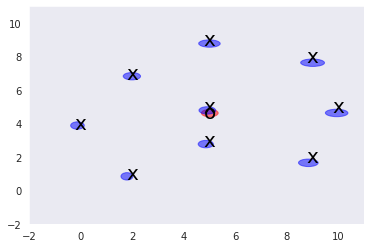

In [23]:
observedLandmarks = np.zeros((1,N))
robSigma = np.zeros((3,3))
robMapSigma = np.zeros((3,2*N))
mapSigma = np.identity((2*N))*1000 # 1000 as a "infinite" or just "high" value
aux1 = np.concatenate((robSigma,robMapSigma),axis = 1)
aux2 = np.concatenate((robMapSigma.T,mapSigma), axis = 1)
sigma = np.concatenate((aux1,aux2),axis = 0)
mu = np.zeros((2*9+3,1),dtype = 'float')

fig,ax = plt.subplots()
camera = Camera(fig)

camera = ekf_loop(mu,sigma,observedLandmarks,fig,ax,camera)[0]

animation = camera.animate()
HTML(animation.to_html5_video())       
        

## Testing

Here I compare the results obtained here with the results obtained by the original Octave code. Note that there are differences due to the different functions that the python and octave libraries have.

In [24]:
def test_total(decimal = 2):
    # input to function
    fig,ax = plt.subplots()
    camera = Camera(fig)
    muini = np.zeros((2*9+3,1),dtype = 'float')
    robSigma = np.zeros((3,3))
    robMapSigma = np.zeros((3,2*N))
    mapSigma = np.identity((2*N))*1000 # 1000 as a "infinite" or just "high" value
    aux1 = np.concatenate((robSigma,robMapSigma),axis = 1)
    aux2 = np.concatenate((robMapSigma.T,mapSigma), axis = 1)
    sigmaini = np.concatenate((aux1,aux2),axis = 0)
    observedLandmarks = np.zeros((1,9))
    
    # desired output
    muresult = np.array([[5.0178],[4.6234],[1.5430]])
    sigmaresult = np.array([[0.1607056,  -0.0557768,  -0.0105228],\
                            [-0.0557768,   0.1671933,   0.0119245],\
                            [-0.0105228,   0.0119245,   0.0037868]])
    
    
    # function output
    _,testmu,testsigma = ekf_loop(muini,sigmaini,observedLandmarks,fig,ax,camera)
    
    # test
    try:
        print('====================================================================')
        np.testing.assert_almost_equal(testmu, muresult,decimal= decimal)
        print('\x1b[6;30;42m' + 'Test Success for mu in ekf_loop' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for mu in ekf_loop' + '\x1b[0m')
        print(e)
        
    try:
        np.testing.assert_almost_equal(testsigma, sigmaresult,decimal= decimal+1)
        print('====================================================================')
        print('\x1b[6;30;42m' + 'Test Success for sigma in ekf_loop' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for sigma in ekf_loop:' + '\x1b[0m')
        print(e)

def test_prediction(decimal = 2):
    # input to function
    predmu = np.array([[5.04492],[4.42067],[1.55460],[1.80649],[0.83467],[-0.10844],[3.87679],\
    [2.00993],[6.81895],[8.85230],[1.62635],[9.96294],[4.60379],[9.03066],[7.60910],[4.93532],\
    [4.76744],[4.87090],[2.75450],[5.02812],[8.76238]])
    u = data.loc[(data['timestep'] == 330) & (data['sensor'] == 'ODOMETRY')]
    presigma = np.array([[2.6108e-01,  -5.6749e-02,  -1.0594e-02,   1.1899e-01,  -1.9931e-02,   1.5414e-01,   1.2071e-03,   1.8575e-01 , -2.2452e-02,   1.2952e-01,  -9.6479e-02 ,  1.6147e-01,  -1.0754e-01,   1.9297e-01,  -9.7449e-02,   1.6260e-01,-5.3947e-02,   1.4095e-01,  -5.3326e-02,   2.0615e-01,  -5.5533e-02],\
    [  -5.6749e-02,   2.6897e-01,   1.2191e-02,  -1.0836e-02,   1.2655e-01,  -4.9441e-02,   1.0319e-01 , -8.4403e-02,   1.2944e-01,  -2.2330e-02,   2.1129e-01,  -5.7534e-02,   2.2349e-01,  -9.2427e-02,   2.1233e-01,  -5.8696e-02,1.6350e-01,  -3.4450e-02,   1.6275e-01,  -1.0540e-01,   1.6522e-01],\
    [-1.0594e-02,   1.2191e-02,   1.3796e-02,  -1.6596e-03,   3.8382e-03 , -9.4275e-03,  -8.1671e-04,  -1.6430e-02,   4.3996e-03,  -3.9440e-03,   2.0860e-02,  -1.1036e-02,   2.3321e-02,  -1.8038e-02 ,  2.1076e-02,  -1.1296e-02,1.1375e-02,  -6.4802e-03,   1.1235e-02,  -2.0938e-02,   1.1734e-02],\
    [1.1899e-01,  -1.0836e-02,  -1.6596e-03,   1.1266e-01,  -5.2917e-03,   1.1804e-01,  -1.9095e-03,   1.2291e-01,  -5.6064e-03,   1.1426e-01,  -1.6993e-02,   1.1916e-01,  -1.8694e-02,   1.2403e-01,  -1.7138e-02,   1.1932e-01,-1.0452e-02,   1.1600e-01,  -1.0357e-02,   1.2602e-01,  -1.0683e-02],\
    [-1.9931e-02,   1.2655e-01,   3.8382e-03,  -5.2917e-03,   1.1371e-01,  -1.7745e-02,   1.0593e-01,  -2.8980e-02,   1.1446e-01,  -8.9791e-03,   1.4079e-01,  -2.0313e-02,   1.4472e-01,  -3.1570e-02,   1.4112e-01,  -2.0700e-02,1.2566e-01,  -1.3012e-02,   1.2544e-01,  -3.6174e-02,   1.2619e-01],\
    [1.5414e-01,  -4.9441e-02,  -9.4275e-03,   1.1804e-01,  -1.7745e-02,   1.4908e-01,   7.4526e-04 ,  1.7629e-01,  -1.9837e-02,   1.2720e-01,  -8.4449e-02,   1.5505e-01,  -9.4097e-02,   1.8260e-01,  -8.5284e-02,   1.5603e-01,-4.7269e-02,   1.3714e-01,  -4.6730e-02,   1.9389e-01,  -4.8597e-02],\
    [1.2071e-03,   1.0319e-01 , -8.1671e-04,  -1.9095e-03,   1.0593e-01,   7.4526e-04 ,  1.0758e-01,   3.1316e-03 ,  1.0577e-01,  -1.1237e-03 ,  1.0016e-01,   1.2881e-03,   9.9327e-02,   3.6820e-03,   1.0009e-01 ,  1.3707e-03,1.0338e-01,  -2.6522e-04,   1.0343e-01,   4.6616e-03,   1.0327e-01],\
    [1.8575e-01,  -8.4403e-02,  -1.6430e-02,   1.2291e-01,  -2.8980e-02,   1.7629e-01,   3.1316e-03,   2.2457e-01,  -3.2848e-02,   1.3882e-01,  -1.4541e-01,   1.8735e-01,  -1.6223e-01,   2.3540e-01 , -1.4687e-01 ,  1.8903e-01,-8.0603e-02,   1.5610e-01 , -7.9612e-02,   2.5507e-01,  -8.2915e-02],\
    [-2.2452e-02,   1.2944e-01,   4.3996e-03,  -5.6064e-03,   1.1446e-01,  -1.9837e-02,   1.0577e-01,  -3.2848e-02,   1.1572e-01,  -9.8738e-03,   1.4580e-01,  -2.2882e-02,   1.5031e-01,  -3.5759e-02,   1.4619e-01,  -2.3327e-02,1.2843e-01,  -1.4501e-02,   1.2814e-01,  -4.1035e-02,   1.2905e-01],\
    [1.2952e-01 , -2.2330e-02,  -3.9440e-03,   1.1426e-01,  -8.9791e-03,   1.2720e-01,  -1.1237e-03,   1.3882e-01,  -9.8738e-03,   1.1842e-01,  -3.6883e-02,   1.2992e-01,  -4.0882e-02,   1.4147e-01,  -3.7199e-02,   1.3030e-01,-2.1392e-02,   1.2239e-01,  -2.1184e-02,   1.4618e-01,  -2.1935e-02],\
    [-9.6479e-02,   2.1129e-01,   2.0860e-02 , -1.6993e-02,   1.4079e-01,  -8.4449e-02,   1.0016e-01,  -1.4541e-01,   1.4580e-01,  -3.6883e-02,   2.8941e-01,  -9.8511e-02,   3.1067e-01,  -1.5933e-01,   2.9118e-01,  -1.0063e-01,2.0647e-01,  -5.8939e-02,   2.0514e-01,  -1.8441e-01,   2.0949e-01],\
    [1.6147e-01,  -5.7534e-02 , -1.1036e-02,   1.1916e-01 , -2.0313e-02,   1.5505e-01,   1.2881e-03,   1.8735e-01,  -2.2882e-02 ,  1.2992e-01,  -9.8511e-02,   1.6285e-01,  -1.0988e-01,   1.9480e-01,  -9.9591e-02,   1.6367e-01,-5.4965e-02,   1.4151e-01,  -5.4295e-02,   2.0797e-01,  -5.6577e-02],\
    [-1.0754e-01,   2.2349e-01,   2.3321e-02 , -1.8694e-02,   1.4472e-01,  -9.4097e-02,   9.9327e-02,  -1.6223e-01,   1.5031e-01,  -4.0882e-02,   3.1067e-01,  -1.0988e-01,   3.3472e-01,  -1.7781e-01,   3.1287e-01,  -1.1218e-01,2.1812e-01,  -6.5564e-02,   2.1662e-01,  -2.0584e-01,   2.2152e-01],\
    [1.9297e-01 , -9.2427e-02,  -1.8038e-02,   1.2403e-01,  -3.1570e-02,   1.8260e-01,   3.6820e-03,   2.3540e-01,  -3.5759e-02,   1.4147e-01,  -1.5933e-01,   1.9480e-01,  -1.7781e-01,   2.4811e-01,  -1.6079e-01,   1.9658e-01,-8.8286e-02,   1.6044e-01,  -8.7155e-02,   2.6931e-01,  -9.0957e-02],\
    [-9.7449e-02 ,  2.1233e-01,   2.1076e-02,  -1.7138e-02,   1.4112e-01,  -8.5284e-02,   1.0009e-01,  -1.4687e-01,   1.4619e-01,  -3.7199e-02,   2.9118e-01,  -9.9591e-02,   3.1287e-01,  -1.6079e-01,   2.9341e-01,  -1.0164e-01,2.0748e-01,  -5.9509e-02,   2.0612e-01,  -1.8624e-01,   2.1054e-01],\
    [1.6260e-01,  -5.8696e-02,  -1.1296e-02,   1.1932e-01,  -2.0700e-02,   1.5603e-01,   1.3707e-03,   1.8903e-01,  -2.3327e-02,   1.3030e-01,  -1.0063e-01,   1.6367e-01,  -1.1218e-01,   1.9658e-01,  -1.0164e-01,   1.6488e-01,-5.6116e-02,   1.4217e-01,  -5.5455e-02,   2.1010e-01 , -5.7733e-02],\
    [-5.3947e-02,   1.6436e-01,   1.1394e-02,  -1.0472e-02,  1.2570e-01,  -4.7379e-02,   1.0337e-01,  -8.0808e-02,   1.2849e-01 , -2.1446e-02,   2.0674e-01,  -5.5111e-02,   2.1841e-01,  -8.8508e-02,   2.0774e-01 , -5.6242e-02, 1.6184e-01,  -3.3445e-02,   1.6102e-01,  -1.0218e-01,   1.6339e-01],\
    [1.4095e-01,  -3.4946e-02,  -6.4906e-03,   1.1601e-01, -1.3041e-02,   1.3721e-01,  -2.5900e-04,   1.5622e-01, -1.4534e-02 ,  1.2242e-01,  -5.9092e-02,   1.4160e-01,  -6.5735e-02,   1.6057e-01,  -5.9664e-02,   1.4225e-01, -3.3445e-02,   1.2933e-01,  -3.3040e-02,   1.6835e-01,  -3.4366e-02],\
    [-5.3326e-02,   1.6360e-01,   1.1250e-02 , -1.0376e-02,   1.2548e-01 , -4.6834e-02,   1.0342e-01,  -7.9803e-02,   1.2819e-01,  -2.1235e-02 ,  2.0537e-01,  -5.4431e-02,   2.1688e-01,  -8.7360e-02,   2.0636e-01,  -5.5574e-02,1.6102e-01,  -3.3040e-02,   1.6050e-01, -1.0087e-01, 1.6259e-01],\
    [2.0615e-01,  -1.0699e-01,  -2.0970e-02,   1.2606e-01,  -3.6263e-02,   1.9411e-01,   4.6805e-03,   2.5546e-01,  -4.1141e-02,   1.4628e-01,  -1.8489e-01,   2.0825e-01,  -2.0638e-01 ,  2.6973e-01,  -1.8673e-01,   2.1035e-01, -1.0218e-01,   1.6835e-01 , -1.0087e-01,   2.9488e-01,  -1.0522e-01],\
    [-5.5533e-02,   1.6612e-01,   1.1753e-02,  -1.0704e-02,   1.2624e-01 , -4.8714e-02,   1.0326e-01,  -8.3133e-02,   1.2911e-01,  -2.1992e-02,   2.0978e-01,  -5.6735e-02,   2.2183e-01,  -9.1199e-02,  2.1083e-01,  -5.7870e-02,1.6339e-01,  -3.4366e-02,   1.6259e-01,  -1.0522e-01,   1.6541e-01]])
    
    # desired output
    predmuresult =np.array([[5.04656],[4.52065],[1.55445],[1.80649],[0.83467],[-0.10844],[3.87679],\
    [2.00993],[6.81895],[8.85230],[1.62635],[9.96294],[4.60379],[9.03066],[7.60910],\
    [4.93532],[4.76744],[4.87090],[2.75450],[5.02812],[8.76238]])          
    sigmaresult = np.array([[2.6108e-01, -5.6749e-02, -1.0594e-02,   1.1899e-01,  -1.9931e-02,   1.5414e-01,   1.2071e-03,   1.8575e-01,  -2.2452e-02,   1.2952e-01,  -9.6479e-02,   1.6147e-01,  -1.0754e-01,   1.9297e-01,  -9.7449e-02,   1.6260e-01, -5.3573e-02,   1.4073e-01,  -5.2965e-02,   2.0545e-01,  -5.5147e-02],\
    [-5.5777e-02,   1.6719e-01,   1.1924e-02,  -1.0710e-02,   1.2625e-01,  -4.8728e-02,   1.0326e-01,  -8.3151e-02,   1.2910e-01,  -2.2023e-02,   2.0970e-01,  -5.6684e-02 ,  2.2172e-01,  -9.1057e-02,   2.1073e-01,  -5.7846e-02, 1.6350e-01,  -3.4450e-02,   1.6275e-01,  -1.0540e-01,   1.6522e-01],\
    [-1.0523e-02 ,  1.1924e-02,   3.7868e-03,  -1.6571e-03,   3.8324e-03,  -9.4136e-03,  -8.1547e-04,  -1.6404e-02,   4.3922e-03,  -3.9369e-03,   2.0828e-02,  -1.1017e-02,   2.3286e-02,  -1.8010e-02,   2.1044e-02,  -1.1280e-02, 1.1375e-02,  -6.4802e-03,   1.1235e-02,  -2.0938e-02,   1.1734e-02],\
    [1.1893e-01,  -1.0710e-02,  -1.6571e-03,   1.1266e-01,  -5.2842e-03,   1.1802e-01,  -1.9111e-03,   1.2287e-01, -5.5982e-03,   1.1425e-01,  -1.6955e-02,   1.1913e-01,  -1.8652e-02,   1.2399e-01,  -1.7100e-02,   1.1930e-01, -1.0452e-02,   1.1600e-01,  -1.0357e-02,   1.2602e-01,  -1.0683e-02],\
    [ -1.9801e-02,   1.2625e-01,   3.8324e-03,  -5.2842e-03,   1.1370e-01,  -1.7704e-02,   1.0593e-01,  -2.8907e-02,   1.1444e-01,  -8.9590e-03,   1.4070e-01,  -2.0261e-02,   1.4462e-01,  -3.1492e-02,   1.4103e-01,  -2.0653e-02,1.2566e-01,  -1.3012e-02 ,  1.2544e-01 , -3.6174e-02 ,  1.2619e-01],\
    [1.5382e-01,  -4.8728e-02,  -9.4136e-03,   1.1802e-01,  -1.7704e-02,   1.4898e-01,   7.3662e-04,   1.7611e-01,  -1.9791e-02,   1.2716e-01,  -8.4240e-02,   1.5492e-01,  -9.3865e-02,   1.8241e-01,  -8.5073e-02,   1.5592e-01,-4.7269e-02,   1.3714e-01,  -4.6730e-02,   1.9389e-01,  -4.8597e-02],\
    [1.1794e-03,   1.0326e-01,  -8.1547e-04,  -1.9111e-03,   1.0593e-01,   7.3662e-04,   1.0757e-01,   3.1162e-03,   1.0577e-01,  -1.1279e-03,   1.0018e-01,   1.2770e-03,   9.9347e-02,   3.6656e-03,   1.0011e-01,   1.3608e-03, 1.0338e-01,  -2.6522e-04,   1.0343e-01,   4.6616e-03,   1.0327e-01],\
    [1.8519e-01,  -8.3151e-02,  -1.6404e-02,   1.2287e-01,  -2.8907e-02,   1.7611e-01,   3.1162e-03,   2.2425e-01,  -3.2761e-02,   1.3873e-01,  -1.4503e-01,   1.8713e-01,  -1.6181e-01,   2.3506e-01,  -1.4648e-01,   1.8883e-01, -8.0603e-02,   1.5610e-01,  -7.9612e-02,   2.5507e-01,  -8.2915e-02],\
    [-2.2306e-02,   1.2910e-01,   4.3922e-03,  -5.5982e-03,   1.1444e-01,  -1.9791e-02,   1.0577e-01 , -3.2761e-02,   1.1570e-01,  -9.8519e-03 ,  1.4569e-01,  -2.2823e-02,   1.5019e-01,  -3.5667e-02,   1.4608e-01,  -2.3275e-02,1.2843e-01,  -1.4501e-02,   1.2814e-01,  -4.1035e-02,   1.2905e-01],\
    [1.2938e-01,  -2.2023e-02,  -3.9369e-03,   1.1425e-01,  -8.9590e-03,   1.2716e-01,  -1.1279e-03,   1.3873e-01,  -9.8519e-03,   1.1840e-01,  -3.6779e-02,   1.2986e-01,  -4.0767e-02,   1.4138e-01,  -3.7095e-02,   1.3024e-01,-2.1392e-02,   1.2239e-01,  -2.1184e-02,   1.4618e-01,  -2.1935e-02],\
    [-9.5795e-02,   2.0970e-01,   2.0828e-02,  -1.6955e-02,   1.4070e-01,  -8.4240e-02,   1.0018e-01,  -1.4503e-01,   1.4569e-01,  -3.6779e-02,   2.8891e-01,  -9.8239e-02,   3.1012e-01,  -1.5891e-01,   2.9067e-01,  -1.0039e-01,2.0647e-01,  -5.8939e-02,   2.0514e-01,  -1.8441e-01,   2.0949e-01],\
    [1.6109e-01,  -5.6684e-02,  -1.1017e-02,   1.1913e-01,  -2.0261e-02,   1.5492e-01,   1.2770e-03,   1.8713e-01,  -2.2823e-02,   1.2986e-01,  -9.8239e-02,   1.6268e-01,  -1.0957e-01,   1.9456e-01,  -9.9313e-02,   1.6352e-01, -5.4965e-02,   1.4151e-01,  -5.4295e-02,   2.0797e-01,  -5.6577e-02],\
    [-1.0677e-01,   2.2172e-01,   2.3286e-02,  -1.8652e-02,   1.4462e-01,  -9.3865e-02,   9.9347e-02,  -1.6181e-01,   1.5019e-01,  -4.0767e-02,   3.1012e-01,  -1.0957e-01,   3.3411e-01,  -1.7735e-01,   3.1231e-01,  -1.1192e-01, 2.1812e-01,  -6.5564e-02,   2.1662e-01,  -2.0584e-01,   2.2152e-01],\
    [1.9236e-01,  -9.1057e-02,  -1.8010e-02,   1.2399e-01,  -3.1492e-02,   1.8241e-01 ,  3.6656e-03,   2.3506e-01,  -3.5667e-02,   1.4138e-01,  -1.5891e-01,   1.9456e-01,  -1.7735e-01,   2.4774e-01,  -1.6037e-01,   1.9637e-01,-8.8286e-02,   1.6044e-01,  -8.7155e-02,   2.6931e-01,  -9.0957e-02],\
    [-9.6757e-02,   2.1073e-01,   2.1044e-02,  -1.7100e-02,   1.4103e-01 , -8.5073e-02,   1.0011e-01,  -1.4648e-01,   1.4608e-01,  -3.7095e-02,   2.9067e-01,  -9.9313e-02,   3.1231e-01,  -1.6037e-01,   2.9291e-01,  -1.0140e-01, 2.0748e-01,  -5.9509e-02,   2.0612e-01,  -1.8624e-01,   2.1054e-01],\
    [1.6222e-01,  -5.7846e-02,  -1.1280e-02,   1.1930e-01,  -2.0653e-02,   1.5592e-01,   1.3608e-03,   1.8883e-01,  -2.3275e-02,   1.3024e-01,  -1.0039e-01,   1.6352e-01,  -1.1192e-01,   1.9637e-01,  -1.0140e-01,   1.6475e-01, -5.6116e-02,   1.4217e-01,  -5.5455e-02 ,  2.1010e-01,  -5.7733e-02],\
    [-5.3573e-02,   1.6350e-01,   1.1375e-02,  -1.0452e-02 ,  1.2566e-01,  -4.7269e-02,   1.0338e-01,  -8.0603e-02,   1.2843e-01,  -2.1392e-02,   2.0647e-01,  -5.4965e-02,   2.1812e-01,  -8.8286e-02,   2.0748e-01,  -5.6116e-02,1.6184e-01,  -3.3445e-02,   1.6102e-01,  -1.0218e-01,   1.6339e-01],\
    [ 1.4073e-01,  -3.4450e-02,  -6.4802e-03,   1.1600e-01,  -1.3012e-02,   1.3714e-01,  -2.6522e-04,   1.5610e-01,  -1.4501e-02,   1.2239e-01,  -5.8939e-02,   1.4151e-01,  -6.5564e-02,   1.6044e-01,  -5.9509e-02,   1.4217e-01, -3.3445e-02,   1.2933e-01 , -3.3040e-02,   1.6835e-01,  -3.4366e-02],\
    [ -5.2965e-02,   1.6275e-01,   1.1235e-02,  -1.0357e-02,   1.2544e-01,  -4.6730e-02,   1.0343e-01,  -7.9612e-02,   1.2814e-01,  -2.1184e-02,   2.0514e-01,  -5.4295e-02,   2.1662e-01,  -8.7155e-02 ,  2.0612e-01 , -5.5455e-02,1.6102e-01,  -3.3040e-02,   1.6050e-01,  -1.0087e-01,   1.6259e-01],\
    [ 2.0545e-01 , -1.0540e-01,  -2.0938e-02,   1.2602e-01,  -3.6174e-02,   1.9389e-01,   4.6616e-03,   2.5507e-01,  -4.1035e-02,   1.4618e-01,  -1.8441e-01,   2.0797e-01,  -2.0584e-01,   2.6931e-01,  -1.8624e-01,   2.1010e-01,-1.0218e-01,   1.6835e-01,  -1.0087e-01,   2.9488e-01,  -1.0522e-01],\
    [-5.5147e-02,   1.6522e-01,   1.1734e-02,  -1.0683e-02,   1.2619e-01,  -4.8597e-02,   1.0327e-01,  -8.2915e-02,   1.2905e-01,  -2.1935e-02,   2.0949e-01,  -5.6577e-02,   2.2152e-01,  -9.0957e-02,   2.1054e-01,  -5.7733e-02, 1.6339e-01,  -3.4366e-02,   1.6259e-01,  -1.0522e-01,   1.6541e-01]])
    
    # function output
    testmu, testsigma = prediction_step(predmu,presigma,u)
    
    # test
    try:
        print('====================================================================')
        np.testing.assert_almost_equal(testmu, predmuresult,decimal= decimal)
        print('\x1b[6;30;42m' + 'Test Success for mu in prediction_step' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for mu in prediction_step' + '\x1b[0m')
        print(e)
        
    try:
        np.testing.assert_almost_equal(testsigma, sigmaresult,decimal= decimal+1)
        print('====================================================================')
        print('\x1b[6;30;42m' + 'Test Success for sigma in prediction_step' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for sigma in prediction_step:' + '\x1b[0m')
        print(e)
        
        
def test_correction(decimal = 2):
    # input values
    muinput = np.array([[5.04656],[4.52065],[1.55445],[1.80649],[0.83467],[-0.10844],\
               [3.87679],[2.00993],[6.81895],[8.85230],[1.62635],[9.96294],[4.60379],\
               [9.03066],[7.60910],[4.93532],[4.76744],[4.87090],[2.75450],[5.02812],[8.76238]])
    sigmainput = np.array([[2.6108e-01,  -5.6749e-02,  -1.0594e-02,   1.1899e-01,  -1.9931e-02,   1.5414e-01,   1.2071e-03,   1.8575e-01,  -2.2452e-02,   1.2952e-01,  -9.6479e-02,   1.6147e-01,  -1.0754e-01,   1.9297e-01,  -9.7449e-02,   1.6260e-01,-5.3947e-02,   1.4095e-01,  -5.3326e-02,   2.0615e-01,  -5.5533e-02],\
            [-5.6749e-02,   2.6897e-01,   1.2191e-02,  -1.0836e-02,   1.2655e-01,  -4.9441e-02 ,  1.0319e-01,  -8.4403e-02,   1.2944e-01,  -2.2330e-02,   2.1129e-01,  -5.7534e-02,   2.2349e-01,  -9.2427e-02,   2.1233e-01,  -5.8696e-02, 1.6436e-01,  -3.4946e-02,   1.6360e-01,  -1.0699e-01,   1.6612e-01],\
            [-1.0594e-02,   1.2191e-02,   1.3796e-02,  -1.6596e-03,   3.8382e-03,  -9.4275e-03,  -8.1671e-04,  -1.6430e-02,   4.3996e-03,  -3.9440e-03,   2.0860e-02,  -1.1036e-02,   2.3321e-02,  -1.8038e-02,   2.1076e-02,  -1.1296e-02,1.1394e-02,  -6.4906e-03,   1.1250e-02,  -2.0970e-02,   1.1753e-02],\
            [1.1899e-01 , -1.0836e-02,  -1.6596e-03,   1.1266e-01,  -5.2917e-03,   1.1804e-01,  -1.9095e-03,   1.2291e-01,  -5.6064e-03,   1.1426e-01,  -1.6993e-02,   1.1916e-01,  -1.8694e-02,   1.2403e-01,  -1.7138e-02,   1.1932e-01,-1.0472e-02,   1.1601e-01,  -1.0376e-02,   1.2606e-01,  -1.0704e-02],\
            [-1.9931e-02,   1.2655e-01,   3.8382e-03,  -5.2917e-03,   1.1371e-01,  -1.7745e-02,   1.0593e-01,  -2.8980e-02,   1.1446e-01,  -8.9791e-03,   1.4079e-01,  -2.0313e-02,   1.4472e-01,  -3.1570e-02,   1.4112e-01,  -2.0700e-02,1.2570e-01,  -1.3041e-02 ,  1.2548e-01,  -3.6263e-02,   1.2624e-01],\
            [1.5414e-01,  -4.9441e-02,  -9.4275e-03,   1.1804e-01,  -1.7745e-02,   1.4908e-01,   7.4526e-04,   1.7629e-01,  -1.9837e-02 ,  1.2720e-01,  -8.4449e-02,   1.5505e-01,  -9.4097e-02,   1.8260e-01,  -8.5284e-02,   1.5603e-01,-4.7379e-02,   1.3721e-01,  -4.6834e-02,   1.9411e-01,  -4.8714e-02],\
            [1.2071e-03,   1.0319e-01,  -8.1671e-04,  -1.9095e-03,   1.0593e-01,   7.4526e-04,   1.0758e-01,   3.1316e-03,   1.0577e-01,  -1.1237e-03,   1.0016e-01,   1.2881e-03,   9.9327e-02,   3.6820e-03,   1.0009e-01,   1.3707e-03,1.0337e-01,  -2.5900e-04,   1.0342e-01,   4.6805e-03,   1.0326e-01],\
            [1.8575e-01,  -8.4403e-02,  -1.6430e-02,   1.2291e-01,  -2.8980e-02,   1.7629e-01,   3.1316e-03,   2.2457e-01,  -3.2848e-02,   1.3882e-01,  -1.4541e-01,   1.8735e-01,  -1.6223e-01,   2.3540e-01,  -1.4687e-01,   1.8903e-01,-8.0808e-02,   1.5622e-01,  -7.9803e-02,   2.5546e-01,  -8.3133e-02],\
            [-2.2452e-02,   1.2944e-01,   4.3996e-03,  -5.6064e-03,   1.1446e-01,  -1.9837e-02,   1.0577e-01,  -3.2848e-02,   1.1572e-01,  -9.8738e-03,   1.4580e-01,  -2.2882e-02,   1.5031e-01,  -3.5759e-02,   1.4619e-01,  -2.3327e-02,1.2849e-01,  -1.4534e-02,   1.2819e-01,  -4.1141e-02,   1.2911e-01],\
            [1.2952e-01,  -2.2330e-02,  -3.9440e-03,   1.1426e-01,  -8.9791e-03,   1.2720e-01,  -1.1237e-03,   1.3882e-01,  -9.8738e-03,   1.1842e-01,  -3.6883e-02,   1.2992e-01,  -4.0882e-02,   1.4147e-01,  -3.7199e-02,   1.3030e-01,-2.1446e-02,   1.2242e-01,  -2.1235e-02,   1.4628e-01,  -2.1992e-02],\
            [-9.6479e-02,   2.1129e-01,   2.0860e-02,  -1.6993e-02,   1.4079e-01,  -8.4449e-02 ,  1.0016e-01,  -1.4541e-01,   1.4580e-01 , -3.6883e-02,   2.8941e-01,  -9.8511e-02,   3.1067e-01,  -1.5933e-01,   2.9118e-01,  -1.0063e-01,2.0674e-01,  -5.9092e-02,   2.0537e-01,  -1.8489e-01,   2.0978e-01],\
            [1.6147e-01,  -5.7534e-02,  -1.1036e-02,   1.1916e-01,  -2.0313e-02,   1.5505e-01,   1.2881e-03,   1.8735e-01,  -2.2882e-02,   1.2992e-01,  -9.8511e-02,   1.6285e-01,  -1.0988e-01,   1.9480e-01,  -9.9591e-02,   1.6367e-01,-5.5111e-02,   1.4160e-01,  -5.4431e-02,   2.0825e-01,  -5.6735e-02],\
            [-1.0754e-01,   2.2349e-01,   2.3321e-02,  -1.8694e-02,   1.4472e-01,  -9.4097e-02,   9.9327e-02,  -1.6223e-01,   1.5031e-01,  -4.0882e-02,   3.1067e-01,  -1.0988e-01,   3.3472e-01,  -1.7781e-01,   3.1287e-01,  -1.1218e-01,2.1841e-01,  -6.5735e-02,   2.1688e-01,  -2.0638e-01,   2.2183e-01],\
            [1.9297e-01,  -9.2427e-02,  -1.8038e-02,   1.2403e-01,  -3.1570e-02,   1.8260e-01,   3.6820e-03,   2.3540e-01,  -3.5759e-02,   1.4147e-01,  -1.5933e-01,   1.9480e-01,  -1.7781e-01,   2.4811e-01,  -1.6079e-01,   1.9658e-01,-8.8508e-02,   1.6057e-01,  -8.7360e-02,   2.6973e-01,  -9.1199e-02],\
            [-9.7449e-02,   2.1233e-01,   2.1076e-02,  -1.7138e-02,   1.4112e-01,  -8.5284e-02 ,  1.0009e-01,  -1.4687e-01,   1.4619e-01,  -3.7199e-02,   2.9118e-01,  -9.9591e-02,   3.1287e-01,  -1.6079e-01,   2.9341e-01,  -1.0164e-01, 2.0774e-01,  -5.9664e-02 ,  2.0636e-01,  -1.8673e-01,   2.1083e-01],\
            [1.6260e-01,  -5.8696e-02,  -1.1296e-02,   1.1932e-01,  -2.0700e-02,   1.5603e-01,   1.3707e-03,   1.8903e-01,  -2.3327e-02,   1.3030e-01,  -1.0063e-01,   1.6367e-01,  -1.1218e-01,   1.9658e-01,  -1.0164e-01,   1.6488e-01,-5.6242e-02,   1.4225e-01,  -5.5574e-02,   2.1035e-01,  -5.7870e-02],\
            [-5.3947e-02,   1.6436e-01,   1.1394e-02,  -1.0472e-02,   1.2570e-01,  -4.7379e-02,   1.0337e-01, -8.0808e-02,   1.2849e-01,  -2.1446e-02,   2.0674e-01,  -5.5111e-02,   2.1841e-01,  -8.8508e-02,   2.0774e-01,  -5.6242e-02, 1.6198e-01,  -3.3526e-02,   1.6115e-01,  -1.0244e-01,   1.6354e-01],\
            [1.4095e-01,  -3.4946e-02,  -6.4906e-03,   1.1601e-01,  -1.3041e-02,   1.3721e-01,  -2.5900e-04,   1.5622e-01,  -1.4534e-02,   1.2242e-01,  -5.9092e-02,   1.4160e-01,  -6.5735e-02,   1.6057e-01,  -5.9664e-02,   1.4225e-01, -3.3526e-02,   1.2938e-01,  -3.3115e-02,   1.6851e-01,  -3.4452e-02],\
            [-5.3326e-02,   1.6360e-01,   1.1250e-02,  -1.0376e-02,   1.2548e-01,  -4.6834e-02 ,  1.0342e-01,  -7.9803e-02,   1.2819e-01,  -2.1235e-02,   2.0537e-01,  -5.4431e-02,   2.1688e-01,  -8.7360e-02,   2.0636e-01,  -5.5574e-02,  1.6115e-01,  -3.3115e-02,   1.6062e-01,  -1.0111e-01,   1.6273e-01],\
            [2.0615e-01,  -1.0699e-01,  -2.0970e-02,   1.2606e-01,  -3.6263e-02,   1.9411e-01,   4.6805e-03,   2.5546e-01,  -4.1141e-02,   1.4628e-01,  -1.8489e-01,   2.0825e-01,  -2.0638e-01,   2.6973e-01,  -1.8673e-01,   2.1035e-01,  -1.0244e-01,   1.6851e-01,  -1.0111e-01,   2.9537e-01,  -1.0550e-01],\
            [-5.5533e-02,   1.6612e-01,   1.1753e-02,  -1.0704e-02,   1.2624e-01,  -4.8714e-02,   1.0326e-01,  -8.3133e-02,   1.2911e-01,  -2.1992e-02,   2.0978e-01,  -5.6735e-02,   2.2183e-01,  -9.1199e-02,   2.1083e-01,  -5.7870e-02,   1.6354e-01,  -3.4452e-02,   1.6273e-01,  -1.0550e-01,   1.6559e-01]])
    observedLandmarks = np.ones((1,9))
    # desired values
    corrmu = np.array([[5.01782],[4.62335],[1.54298],[1.80461],[0.83901],[-0.11898],[3.87586],\
          [1.99148],[6.82428],[8.84647],[1.65308],[9.94389],[4.63452], [9.00673],\
          [7.63752],[4.92296],[4.78357],[4.86310],[2.76855],[5.00123],[8.78071]])
    corrsigma = np.array([[1.6071e-01,  -5.5777e-02,  -1.0523e-02,   1.1893e-01,  -1.9801e-02,   1.5382e-01,   1.1794e-03,   1.8519e-01,  -2.2306e-02,   1.2938e-01,  -9.5795e-02,   1.6109e-01 , -1.0677e-01,   1.9236e-01,  -9.6757e-02,   1.6222e-01, -5.3573e-02,   1.4073e-01,  -5.2965e-02,   2.0545e-01,  -5.5147e-02],\
                        [-5.5777e-02,   1.6719e-01,   1.1924e-02,  -1.0710e-02,   1.2625e-01,  -4.8728e-02,   1.0326e-01,  -8.3151e-02,   1.2910e-01,  -2.2023e-02,   2.0970e-01,  -5.6684e-02,   2.2172e-01,  -9.1057e-02,   2.1073e-01,  -5.7846e-02, 1.6350e-01,  -3.4450e-02,   1.6275e-01,  -1.0540e-01,   1.6522e-01],\
                        [-1.0523e-02,   1.1924e-02,   3.7868e-03,  -1.6571e-03,   3.8324e-03,  -9.4136e-03,  -8.1547e-04 , -1.6404e-02,   4.3922e-03,  -3.9369e-03,   2.0828e-02 , -1.1017e-02,   2.3286e-02,  -1.8010e-02,   2.1044e-02,  -1.1280e-02,1.1375e-02,  -6.4802e-03,   1.1235e-02,  -2.0938e-02,   1.1734e-02],\
                        [1.1893e-01,  -1.0710e-02,  -1.6571e-03,   1.1266e-01,  -5.2842e-03,   1.1802e-01,  -1.9111e-03,   1.2287e-01,  -5.5982e-03,   1.1425e-01,  -1.6955e-02,   1.1913e-01,  -1.8652e-02,   1.2399e-01,  -1.7100e-02,   1.1930e-01,-1.0452e-02,   1.1600e-01,  -1.0357e-02,   1.2602e-01,  -1.0683e-02],\
                        [-1.9801e-02,   1.2625e-01,   3.8324e-03,  -5.2842e-03 ,  1.1370e-01,  -1.7704e-02,   1.0593e-01,  -2.8907e-02,   1.1444e-01,  -8.9590e-03,   1.4070e-01 , -2.0261e-02,   1.4462e-01,  -3.1492e-02,   1.4103e-01,  -2.0653e-02,1.2566e-01,  -1.3012e-02,   1.2544e-01,  -3.6174e-02,   1.2619e-01],\
                        [1.5382e-01,  -4.8728e-02,  -9.4136e-03,   1.1802e-01,  -1.7704e-02,   1.4898e-01,   7.3662e-04,   1.7611e-01,  -1.9791e-02,   1.2716e-01,  -8.4240e-02,   1.5492e-01,  -9.3865e-02,   1.8241e-01,  -8.5073e-02,   1.5592e-01,-4.7269e-02,   1.3714e-01,  -4.6730e-02,   1.9389e-01,  -4.8597e-02],\
                        [1.1794e-03,   1.0326e-01,  -8.1547e-04,  -1.9111e-03,   1.0593e-01,   7.3662e-04,   1.0757e-01,   3.1162e-03,   1.0577e-01,  -1.1279e-03,   1.0018e-01,   1.2770e-03,   9.9347e-02,   3.6656e-03,   1.0011e-01,   1.3608e-03,1.0338e-01,  -2.6522e-04,   1.0343e-01,   4.6616e-03,   1.0327e-01],\
                        [1.8519e-01,  -8.3151e-02,  -1.6404e-02,   1.2287e-01,  -2.8907e-02,   1.7611e-01,   3.1162e-03,   2.2425e-01,  -3.2761e-02,   1.3873e-01,  -1.4503e-01,   1.8713e-01,  -1.6181e-01,   2.3506e-01,  -1.4648e-01,   1.8883e-01,-8.0603e-02,   1.5610e-01,  -7.9612e-02,   2.5507e-01,  -8.2915e-02],\
                        [-2.2306e-02,   1.2910e-01,   4.3922e-03,  -5.5982e-03,   1.1444e-01,  -1.9791e-02,   1.0577e-01,  -3.2761e-02,   1.1570e-01,  -9.8519e-03,   1.4569e-01,  -2.2823e-02,   1.5019e-01,  -3.5667e-02,   1.4608e-01,  -2.3275e-02,1.2843e-01,  -1.4501e-02,   1.2814e-01,  -4.1035e-02,  1.2905e-01],\
                        [1.2938e-01,  -2.2023e-02,  -3.9369e-03,   1.1425e-01,  -8.9590e-03,   1.2716e-01,  -1.1279e-03,   1.3873e-01,  -9.8519e-03,   1.1840e-01,  -3.6779e-02,   1.2986e-01,  -4.0767e-02,   1.4138e-01,  -3.7095e-02,   1.3024e-01, -2.1392e-02,   1.2239e-01,  -2.1184e-02,   1.4618e-01,  -2.1935e-02],\
                        [-9.5795e-02,   2.0970e-01,   2.0828e-02,  -1.6955e-02,   1.4070e-01,  -8.4240e-02,   1.0018e-01,  -1.4503e-01,   1.4569e-01,  -3.6779e-02,   2.8891e-01,  -9.8239e-02,   3.1012e-01,  -1.5891e-01,   2.9067e-01,  -1.0039e-01,2.0647e-01,  -5.8939e-02,   2.0514e-01,  -1.8441e-01,   2.0949e-01],\
                        [1.6109e-01,  -5.6684e-02,  -1.1017e-02,   1.1913e-01,  -2.0261e-02,   1.5492e-01,   1.2770e-03,   1.8713e-01,  -2.2823e-02,   1.2986e-01,  -9.8239e-02,   1.6268e-01,  -1.0957e-01,   1.9456e-01,  -9.9313e-02,   1.6352e-01,-5.4965e-02,   1.4151e-01,  -5.4295e-02,   2.0797e-01,  -5.6577e-02],\
                        [-1.0677e-01,   2.2172e-01,   2.3286e-02,  -1.8652e-02,   1.4462e-01,  -9.3865e-02,   9.9347e-02,  -1.6181e-01,   1.5019e-01,  -4.0767e-02,   3.1012e-01,  -1.0957e-01,   3.3411e-01,  -1.7735e-01,   3.1231e-01,  -1.1192e-01,2.1812e-01,  -6.5564e-02,   2.1662e-01,  -2.0584e-01,   2.2152e-01],\
                        [1.9236e-01,  -9.1057e-02,  -1.8010e-02,   1.2399e-01,  -3.1492e-02,   1.8241e-01,   3.6656e-03,   2.3506e-01,  -3.5667e-02,   1.4138e-01,  -1.5891e-01,   1.9456e-01,  -1.7735e-01,   2.4774e-01,  -1.6037e-01,   1.9637e-01,-8.8286e-02,   1.6044e-01,  -8.7155e-02,   2.6931e-01,  -9.0957e-02],\
                        [-9.6757e-02,   2.1073e-01,   2.1044e-02,  -1.7100e-02,   1.4103e-01,  -8.5073e-02,   1.0011e-01,  -1.4648e-01,   1.4608e-01 , -3.7095e-02,   2.9067e-01,  -9.9313e-02,   3.1231e-01,  -1.6037e-01,   2.9291e-01,  -1.0140e-01,2.0748e-01,  -5.9509e-02,   2.0612e-01,  -1.8624e-01,   2.1054e-01],\
                        [1.6222e-01,  -5.7846e-02,  -1.1280e-02,   1.1930e-01,  -2.0653e-02,   1.5592e-01,   1.3608e-03,   1.8883e-01,  -2.3275e-02,   1.3024e-01,  -1.0039e-01,   1.6352e-01,  -1.1192e-01,   1.9637e-01,  -1.0140e-01,   1.6475e-01,-5.6116e-02,   1.4217e-01 , -5.5455e-02,   2.1010e-01,  -5.7733e-02],\
                        [-5.3573e-02,   1.6350e-01 ,  1.1375e-02,  -1.0452e-02,   1.2566e-01,  -4.7269e-02,   1.0338e-01,  -8.0603e-02,   1.2843e-01,  -2.1392e-02,   2.0647e-01,  -5.4965e-02 ,  2.1812e-01,  -8.8286e-02,   2.0748e-01,  -5.6116e-02,1.6184e-01,  -3.3445e-02,   1.6102e-01,  -1.0218e-01,   1.6339e-01],\
                        [1.4073e-01,  -3.4450e-02,  -6.4802e-03,   1.1600e-01,  -1.3012e-02,   1.3714e-01,  -2.6522e-04,   1.5610e-01,  -1.4501e-02,   1.2239e-01,  -5.8939e-02,   1.4151e-01,  -6.5564e-02,   1.6044e-01,  -5.9509e-02,   1.4217e-01,-3.3445e-02,   1.2933e-01,  -3.3040e-02,   1.6835e-01,  -3.4366e-02],\
                        [-5.2965e-02,   1.6275e-01,   1.1235e-02,  -1.0357e-02,   1.2544e-01,  -4.6730e-02,   1.0343e-01,  -7.9612e-02,   1.2814e-01,  -2.1184e-02,   2.0514e-01,  -5.4295e-02,   2.1662e-01,  -8.7155e-02,   2.0612e-01,  -5.5455e-02, 1.6102e-01,  -3.3040e-02,   1.6050e-01,  -1.0087e-01,   1.6259e-01],\
                        [2.0545e-01,  -1.0540e-01,  -2.0938e-02,   1.2602e-01,  -3.6174e-02,   1.9389e-01,   4.6616e-03,   2.5507e-01,  -4.1035e-02,   1.4618e-01,  -1.8441e-01,   2.0797e-01,  -2.0584e-01,   2.6931e-01,  -1.8624e-01,   2.1010e-01,-1.0218e-01,   1.6835e-01,  -1.0087e-01,   2.9488e-01,  -1.0522e-01],\
                        [-5.5147e-02,   1.6522e-01,   1.1734e-02 , -1.0683e-02,   1.2619e-01,  -4.8597e-02,   1.0327e-01,  -8.2915e-02 ,  1.2905e-01,  -2.1935e-02,   2.0949e-01,  -5.6577e-02,   2.2152e-01,  -9.0957e-02,   2.1054e-01,  -5.7733e-02,1.6339e-01,  -3.4366e-02 ,  1.6259e-01,  -1.0522e-01,   1.6541e-01]])
    # test values
    testmu, testsigma, observedLandmarks = correction_step(mu,sigma,data.loc[(data['timestep'] == 330) & (data['sensor'] == 'SENSOR')],observedLandmarks)
    # test
    try:
        print('====================================================================')
        np.testing.assert_almost_equal(testmu, corrmu,decimal= decimal)
        print('\x1b[6;30;42m' + 'Test Success for mu in correction_step' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for mu in correction_step' + '\x1b[0m')
        print(e)

    try:
        np.testing.assert_almost_equal(testsigma, corrsigma,decimal= decimal)
        print('====================================================================')
        print('\x1b[6;30;42m' + 'Test Success for sigma in correction_step' + '\x1b[0m')
    except AssertionError as e:
        print('====================================================================')
        print('\x1b[0;30;41m' + 'Test Failed for sigma in correction_step:' + '\x1b[0m')
        print(e)

Test Success for mu in ekf_loop
Test Success for sigma in ekf_loop


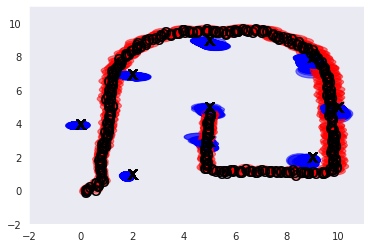

In [25]:
test_total(decimal = 1)

In [26]:
test_prediction(decimal = 1)

Test Success for mu in prediction_step
Test Failed for sigma in prediction_step:

Arrays are not almost equal to 2 decimals

Mismatched elements: 3 / 441 (0.68%)
Max absolute difference: 0.20181353
Max relative difference: 5.28393366
 x: array([[ 3.63e-01, -5.80e-02, -1.20e-02,  1.19e-01, -2.03e-02,  1.55e-01,
         1.29e-03,  1.87e-01, -2.29e-02,  1.30e-01, -9.86e-02,  1.63e-01,
        -1.10e-01,  1.95e-01, -9.96e-02,  1.64e-01, -5.51e-02,  1.42e-01,...
 y: array([[ 2.61e-01, -5.67e-02, -1.06e-02,  1.19e-01, -1.99e-02,  1.54e-01,
         1.21e-03,  1.86e-01, -2.25e-02,  1.30e-01, -9.65e-02,  1.61e-01,
        -1.08e-01,  1.93e-01, -9.74e-02,  1.63e-01, -5.36e-02,  1.41e-01,...


In [27]:
test_correction(decimal = 1)

Test Failed for mu in correction_step

Arrays are not almost equal to 1 decimals

Mismatched elements: 17 / 21 (81%)
Max absolute difference: 14.75384379
Max relative difference: 2.71482664
 x: array([[ 0.1],
       [ 0. ],
       [ 0.1],...
 y: array([[ 5. ],
       [ 4.6],
       [ 1.5],...
Test Failed for sigma in correction_step:

Arrays are not almost equal to 1 decimals

Mismatched elements: 123 / 441 (27.9%)
Max absolute difference: 999.89243
Max relative difference: 9295.27219485
 x: array([[0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],...
 y: array([[ 1.6e-01, -5.6e-02, -1.1e-02,  1.2e-01, -2.0e-02,  1.5e-01,
         1.2e-03,  1.9e-01, -2.2e-02,  1.3e-01, -9.6e-02,  1.6e-01,
        -1.1e-01,  1.9e-01, -9.7e-02,  1.6e-01, -5.4e-02,  1.4e-01,...


In [28]:
mu

array([[ 0.09956596],
       [ 0.01005956],
       [ 0.10086379],
       [ 1.78615901],
       [ 0.87720484],
       [-0.09141201],
       [ 3.85900198],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [29]:
sigma

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.